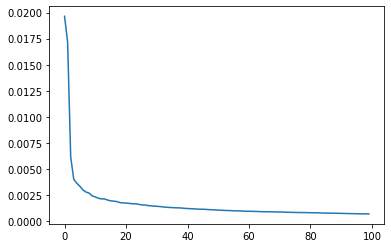

In [30]:
import numpy as np
from scipy.sparse import lil_matrix

# Load data
book_names = np.loadtxt('Books.csv', skiprows=1, delimiter=';', usecols=(0,), dtype=str)
userid, bookname, rating = np.loadtxt(
    'Ratings.csv',
    skiprows=1,
    delimiter=';',
    dtype=str,
    comments=None,
    unpack=True
)

# Get unique users and books
unique_users = np.unique(userid)
book_to_index = {book: idx for idx, book in enumerate(book_names)}
user_to_index = {user: idx for idx, user in enumerate(unique_users)}

# Create a sparse rating matrix
rating_matrix = lil_matrix((len(unique_users), len(book_names)), dtype=np.float32)

# Populate the sparse matrix
for user, book, rate in zip(userid, bookname, rating):
    user_idx = user_to_index[user]
    book_idx = book_to_index.get(book, None)
    if book_idx is not None:  # Skip books not found in book_names
        rating_matrix[user_idx, book_idx] = float(rate)

# You can convert the matrix to other formats (e.g., CSR) if needed
rating_matrix = rating_matrix.tocsr()
#reduce dimenality 
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
rating_matrix = svd.fit_transform(rating_matrix)
#plot components
import matplotlib.pyplot as plt
plt.plot(svd.explained_variance_ratio_)
plt.show()


In [31]:
#Useing only 20 components
svd = TruncatedSVD(n_components=5)
rating_matrix = svd.fit_transform(rating_matrix)
#deallocation
del book_names, userid, bookname, rating, unique_users, book_to_index, user_to_index, user_idx, book_idx, rate, user, book

In [181]:
# Define the ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Define the forward pass for the neural network
def forward_pass(Z, weights, activations):
    for W, phi in zip(weights, activations):
        Z = phi(W @ Z) 
    return Z
def compute_loss(Y, Y_pred, S):
    loss = 0
    for i, j in S:
        loss += (Y[i, j] - Y_pred[i, j]) ** 2
    return loss
# Compute gradients using backpropagation
def backprop(Z, Y, Y_pred, S, weights, activations):
    grads = [np.zeros_like(W) for W in weights]
    m, n = Y.shape

    # Gradient of the loss wrt Y_pred
    dL_dY_pred = np.zeros((m, n))
    for i, j in S:
        dL_dY_pred[i, j] = -2 * (Y[i, j] - Y_pred[i, j])
    dZ = dL_dY_pred
    for l in reversed(range(len(weights))):
        W = weights[l]
        phi = activations[l]
        Z_prev = forward_pass(Z, weights[:l], activations[:l])

        # Gradient wrt weights
#        grads[l] += dZ @ Z_prev.T
        grads[l] += np.dot(dZ, Z_prev.T)  # Matrix multiplication

        # Gradient wrt Z_prev
        dZ = W.T @ dZ * (Z_prev > 0)  # Derivative of ReLU
    
    return grads

def gradient_descent(weights, grads, lr):
    for l in range(len(weights)):
        weights[l] -= lr * grads[l]

def initialize_weights(layers):
    weights = []
    for i in range(len(layers) - 1):
        W = np.random.randn(layers[i + 1], layers[i]) * 0.01  # Small random values
        weights.append(W)
    return weights

# Main function
def matrix_completion_sgd(Y, S, layers, lr=0.01, epochs=50000, batch_size=64):
    m, n = Y.shape
    p = layers[0]

    # Initialize input embedding and weights
    Z = np.random.randn(p, n)  # Random input embedding
    weights = initialize_weights(layers)
    activations = [relu] * (len(layers) - 1)  # ReLU for all hidden layers

    # Get observed entries
    observed_indices = np.argwhere(S == 1)
    # Training loop
    for epoch in range(epochs):
        # Shuffle observed indices
        np.random.shuffle(observed_indices)
        for i in range(0, len(observed_indices), batch_size):
            # Mini-batch indices
            batch_indices = observed_indices[i : i + batch_size]
            # Extract mini-batch data
            batch_Y = np.zeros_like(Y)
            batch_S = np.zeros_like(S)
            for idx in batch_indices:
                row, col = idx
                batch_Y[row, col] = Y[row, col]
                batch_S[row, col] = 1

            # Forward pass
            Y_pred = forward_pass(Z, weights, activations)

            # Compute loss for the mini-batch
            loss = compute_loss(batch_Y, Y_pred, batch_S)

            # Backpropagation for the mini-batch
            grads = backprop(Z, batch_Y, Y_pred, batch_S, weights, activations)
            # Gradient descent step
            gradient_descent(weights, grads, lr)
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")

    return Y_pred

In [ ]:
#

In [ ]:

def generate_synthetic_data(m, n, k, sparsity=0.7, noise_std=0.01):
    """
        m (int): Number of users (rows in the matrix).
        n (int): Number of items (columns in the matrix).
        k (int): Number of hidden preference factors (rank of the matrix).
        sparsity (float): Fraction of missing entries (0 = no missing data, 1 = fully sparse).
        noise_std (float): Standard deviation of Gaussian noise added to the observations.
        Y (ndarray): Observed matrix with missing entries.
        S (ndarray): Binary mask indicating observed entries (1 for observed, 0 for missing).
        Y_true (ndarray): Ground-truth low-rank matrix.
    """
    user_preferences = np.random.randn(m, k)  # User 
    item_preferences = np.random.randn(k, n)  # features
    Y_true = np.dot(user_preferences, item_preferences)  # Low-rank matrix (m x n)
    Y_noisy = Y_true + noise_std * np.random.randn(m, n)
    S = np.random.rand(m, n) > sparsity  # Sparsity mask (1 = observed, 0 = missing)
    Y = np.where(S, Y_noisy, 0)  # Observed entries remain; missing entries set to 0

    return Y, S, Y_true
# Parameters
m = 200           
n = 10           
rank = 4       
sparsity = 0.1    # % entries missing
noise_std = 0.0 #  Gaussian noise
Y, S, Y_true = generate_synthetic_data(m, n, rank, sparsity, noise_std)

# Print shapes
print("Observed matrix Y:", Y.shape)
print("Sparsity mask S:", S.shape)
print("Ground-truth matrix Y_true:", Y_true.shape)
print("Number of observed entries:", np.sum(S))


Observed matrix Y: (200, 10)
Sparsity mask S: (200, 10)
Ground-truth matrix Y_true: (200, 10)
Number of observed entries: 1817


In [226]:
layers = [n, 2 * n, m]
# Create the sparsity mask and convert to list of indices
S = list(zip(*np.where(S == 1)))  # Indices of observed values
Y_pred = matrix_completion(Y, S, layers, lr=0.000001, epochs=10000)
print("Completed Matrix:\n", Y_pred)

Epoch 0, Loss: 6948.176223198103
Epoch 100, Loss: 6948.14931193827
Epoch 200, Loss: 6948.122690152255
Epoch 300, Loss: 6948.096249305134
Epoch 400, Loss: 6948.070009653674
Epoch 500, Loss: 6948.042770602307
Epoch 600, Loss: 6948.015133104781
Epoch 700, Loss: 6947.985724047231
Epoch 800, Loss: 6947.955214001025
Epoch 900, Loss: 6947.923313464234
Epoch 1000, Loss: 6947.890780086463
Epoch 1100, Loss: 6947.857787212285
Epoch 1200, Loss: 6947.823342927888
Epoch 1300, Loss: 6947.787492861689
Epoch 1400, Loss: 6947.750292316724
Epoch 1500, Loss: 6947.711715835777
Epoch 1600, Loss: 6947.67146537224
Epoch 1700, Loss: 6947.629017895323
Epoch 1800, Loss: 6947.584628565883
Epoch 1900, Loss: 6947.539344763941
Epoch 2000, Loss: 6947.491357824223
Epoch 2100, Loss: 6947.439794337104
Epoch 2200, Loss: 6947.384869069005
Epoch 2300, Loss: 6947.326797488988
Epoch 2400, Loss: 6947.264374594028
Epoch 2500, Loss: 6947.199124083188
Epoch 2600, Loss: 6947.128984271747
Epoch 2700, Loss: 6947.0533662272555
Epoch

In [227]:
print("Ground-truth Matrix:\n", Y_true[0])
print("Completed Matrix:\n", Y_pred[0])

Ground-truth Matrix:
 [-0.68470024 -0.19471641  1.30766588  0.95764159  0.80160646 -0.70298037
  0.91177458  0.12749228  0.28065081  0.26736104]
Completed Matrix:
 [0.00027955 0.         0.01106549 0.02789739 0.01633329 0.01423968
 0.         0.00066246 0.01173997 0.02968856]


In [ ]:

def forward_pass(x, weights, activations):
    z = x
    for w, act in zip(weights, activations):
        z = act(np.dot(w, z))  # Apply weight matrix and activation function
    return z

def neural_tangent_kernel(X, weights, activations):
    n = X.shape[1]  # Number of samples
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            x_i = X[:, i].reshape(-1, 1)  # Reshape to (2, 1) for input to the first layer
            x_j = X[:, j].reshape(-1, 1)  # Reshape to (2, 1)
            z_i = forward_pass(x_i, weights, activations)
            z_j = forward_pass(x_j, weights, activations)
            K[i, j] = np.dot(z_i.T, z_j).item()  # Compute dot product between z_i and z_j
    return K

def kernel_ridge_regression(K, Y, S, alpha=1e-3):
    m, n = Y.shape
    observed_indices = np.where(S.ravel() == 1)[0]  # Observed indices
    y_obs = Y.ravel()[observed_indices]
    K_obs = K[np.ix_(observed_indices, observed_indices)]
    
    alpha_I = alpha * np.eye(len(observed_indices))
    alphas = np.linalg.solve(K_obs + alpha_I, y_obs)
    
    K_obs_full = K[:, observed_indices]
    Y_pred = K_obs_full @ alphas
    return Y_pred.reshape(m, n)

# Example usage
m, n = 50, 10
rank = 1
sparsity = 0
X = np.random.rand(2, m * n)  # Inputs as (2, m*n)
weights = [np.random.randn(10, 2)] + [np.random.randn(10, 10) for _ in range(9)]  # 10 layers
activations = [relu] * 10  # 10 layers with ReLU activations

# Assuming generate_synthetic_data is defined elsewhere
Y, S, Y_true = generate_synthetic_data(m, n, rank, sparsity)

K = neural_tangent_kernel(X, weights, activations)
Y_pred = kernel_ridge_regression(K, Y, S)

print("Completed Matrix:\n", Y_pred)
print("Ground Truth Matrix:\n", Y_true)


Completed Matrix:
 [[-2.06063343e-01 -1.61200311e-01 -1.66148873e-02 -1.86683277e-02
  -6.14295441e-02  1.35219428e-01 -3.58565121e-02  1.02945086e-01
  -1.42249266e-02 -3.90438844e-02]
 [-5.51263397e-02 -4.16171175e-01 -3.82931602e-01  4.70745429e-02
  -3.65278232e-02  6.90954716e-02 -6.41113080e-03 -3.14383579e-02
  -2.02374296e-02 -1.10520122e-01]
 [-1.64963073e-01  4.50457518e-03 -3.56606813e-02 -6.89684301e-02
  -6.88199135e-03  3.95933849e-02 -1.43023353e-02  1.15055551e-01
   1.46816316e-01 -3.24425314e-02]
 [ 1.14287025e-01 -2.87580699e-02  1.54578998e-01 -7.58863601e-02
  -2.00648876e-01 -2.87457677e-02 -4.39258798e-02 -4.07818883e-02
  -1.33657024e-01 -5.80637183e-02]
 [ 7.83653369e-02  7.42226520e-02 -3.00327720e-01  1.12839470e-01
   2.94844724e-02 -2.51716733e-02  5.58689833e-02  2.90776881e-02
  -3.80557635e-02 -1.63232625e-02]
 [ 8.72469820e-02  2.76804905e-01 -1.35088919e-01  3.07743057e-01
   1.77960289e-01  1.24674110e-02 -2.99586211e-02 -1.23807408e-01
   8.61213323e

In [311]:
print("Completed Matrix:\n", Y_pred.T[0])
print("Ground Truth Matrix:\n", Y_true.T[0])

Completed Matrix:
 [-0.20606334 -0.05512634 -0.16496307  0.11428703  0.07836534  0.08724698
  0.12811944 -0.03782888 -0.03505179  0.24851912  0.13842535 -0.01287784
 -0.02998658 -0.49633225 -0.04515888  0.13704496 -0.03401559  0.14455046
 -0.03119661 -0.2214463   0.14212784 -0.01723406 -0.03120571  0.08287929
 -0.2002092   0.00675013 -0.03719033 -0.03222688 -0.04569308  0.06037821
  0.14524554 -0.0263888  -0.12918271  0.14293964 -0.34401076  0.14026511
 -0.0303726   0.02520421 -0.54997708  0.02366359 -0.40294179  0.00063334
  0.14080441  0.15470022  0.05915214  0.04320896 -0.00793701 -0.06014708
  0.13654546  0.06731513]
Ground Truth Matrix:
 [ 0.38278806 -0.52162777  0.13911397  0.21325832 -0.50968493  0.19586327
 -0.39414449 -0.72152236 -0.32816575 -0.21936342  0.4478231   0.33158753
 -0.59557814 -0.9482946   0.14263487  0.32103599 -0.6033335   0.23785021
  0.31142567 -0.42822002  0.07780248 -0.2148962   0.05681948  0.24402651
 -0.13011615  0.00642048 -0.25466637  0.13663492 -0.14268